# Práctica 2: Planificación de trayectorias
En la práctica 1 realizamos la estimación de las variables de articulación para un robot de tipo RR utilizando el problema cinemático directo y el problema cinemático inverso. Gracias a ello, pudimos simular el movimiento de un robot a lo largo de una trayectoria rectilínea con velocidad constante, y observar las diferentes indeterminaciones que existían. 

En el mundo real, las trayectorias son más complejas que una línea a velocidad constante. Normalmente se requiere tener en cuenta que comenzamos a velocidad 0 y debemos acabar a la misma velocidad 0, y que la trayectoria no va a ser totalmente recta, puesto que muchas veces tenemos que sortear obstáculos. Para ello podemos usar una trayectoria de tipo 4-3-4. 

En esta práctica realizaremos un planificador de trayectorias de tipo 4-3-4, en las que las velocidades y aceleraciones inicial y final son nulas. Hemos estudiado este tipo de trayectorias en teoría, pero recordaremos que constan de tres fases y que interpolan los puntos de inicio, despegue, asentamiento y fin, que nombramos como $\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$. 

Para ello: 
1. Usaremos las funciones `pcd` y `pci` de la práctica anterior, para poder calcular los parámetros del robot.
2. Definiremos la función `planif`, que tomará como entrada estos puntos, el tiempo de duración de cada uno de los trayectos y el periodo de muestreo (para la representación de la trayectoria). Esta función nos devolverá un array con los coeficientes de las ecuaciones de cada una de las trayectorias. 
3. Evaluaremos $\theta_1(t)$ y $\theta_2(t)$ en cada instante usando dichos coeficientes, y mostraremos el robot utilizando la función `robot`y las animaciones que usamos en la práctica anterior. 
4. Mostraremos también gráficas con el progreso de las variables $\theta_i$, la velocidad y la aceleración del robot en cada instante de tiempo. 

En primer lugar, definiremos las posiciones de los puntos de inicio, despegue, asentamiento y fin ($\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$).

In [1]:
import numpy as np

# Datos de inicio
pini = np.array([1, 0])        # Punto de inicio
pdes = np.array([1, 0.1])      # Punto de despegue
pase = np.array([1.5, 0.1])    # Punto de asentamiento
pfin = np.array([1.5, 0])      # Punto de fin
v0, vf = 0,0                   # Velocidad Inicial y Final Nula
a0, af = 0,0                   # Aceleración Inicial y Final Nula
t1, t2, tn = 1,1,1             # Tiempo de cada segmento de la trayectoria
L1, L2 = 1,1                   # Longitud de los brazos del robot
T = 0.01                       # Periodo de muestreo (para la representación)

### Trayectoria 4-3-4
Como hemos visto en el tema 4, las trayectorias del tipo 4-3-4 siguen unas ecuaciones predefinidas. Para empezar, asumimos que: 
- En el punto de inicio, la aceleración y velocidad son nulas.
- En el punto final la velocidad y aceleración son nulas. 
- En los puntos intermedios debe haber continuidad en posición, velocidad y aceleración. 

A lo largo de la práctica utilizaremos el tiempo normalizado: 

$$ t = \frac{\tau-\tau_{i-1}}{\tau_{i}-\tau_{i-1}} = \frac{\tau-\tau_{i-1}}{t_i} $$

donde $\tau$ es el tiempo real en segundos, $\tau_i$ es el tiempo real al final del $i$-esimo intervalo y $t_i$ es el tiempo total requerido en dicho intervalo. 


Para hacer el desplazamiento con un solo segmento, necesitaríamos un polinomio de grado 8, difícil de resolver y que puede conducir a movimientos extraños y bruscos. Para evitarlo, dividimos la trayectoria en tres segmentos ($h_1$, $h_2$ y $h_n$) con polinomios de grado 4, 3 y 4. Los polinomios que definen el movimiento en cada segmento son:

$$ h_1(t) = a_{14}t^4 + a_{13}t^3 + a_{12}t^2 + a_{11}t + a_{10} $$
$$ h_2(t) = a_{23}t^3 + a_{22}t^2 + a_{21}t + a_{20} $$
$$ h_n(t) = a_{n4}t^4 + a_{n3}t^3 + a_{n2}t^2 + a_{n1}t + a_{n0} $$

Para determinar el movimiento debemos calcular el valor de los 14 coeficientes $a_{ij}$ definidos en los polinomios anteriores. Como hemos visto en clase de teoría, 7 de ellos se pueden calcular directamente a partir de alguna de las restricciones que hemos asumido (velocidad y aceleración iniciales nulas, etc.). Los 7 restantes se pueden calcular a partir de un sistema de 7 ecuaciones con 7 incognitas (véanse las diapositivas 34 y 35 del tema 4) que se puede resolver matricialmente:

$$ \mathbf{x} = \mathbf{C}^{-1}\mathbf{y}$$

siendo:

$$ C = \begin{pmatrix}
1 & 1 & 0 & 0 & 0 & 0 & 0 \\
\frac{3}{t_1} & \frac{4}{t_1} & -\frac{1}{t_2} & 0 & 0 & 0 & 0 \\
\frac{6}{t_1^2} & \frac{12}{t_1^2} & 0 & -\frac{2}{t_2^2} & 0 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 0 & 0 \\
0 & 0 & \frac{1}{t_2} & \frac{2}{t_2} & \frac{3}{t_2} & -\frac{3}{t_n} & \frac{4}{t_n} \\
0 & 0 & 0 & \frac{2}{t_2^2} & \frac{6}{t_2^2} & \frac{6}{t_n^2} & -\frac{12}{t_n^2} \\
0 & 0 & 0 & 0 & 0 & 1 & -1 
\end{pmatrix}  $$

$$ \mathbf{y} = (\delta_1 - \frac{a_0t_1^2}{2}-v_0t_1, -a_0t1-v_0, -a_0, \delta_2, -a_ft_n + v_f, a_f, \delta_n + \frac{a_ft_n^2}{2}-v_ft_n)$$

por lo que $\mathbf{x}$ tendría la siguiente forma:

$$ \mathbf{x} = (a_{13}, a_{14}, a_{21}, a_{22}, a_{23}, a_{n3}, a_{n4})$$


En la definición de $\mathbf{y}$, los valores $a$ y $v$ representan la aceleración y la velocidad en los puntos inicial y final (no deben confundirse con los coeficientes $a_{ij}$), mientras que $\delta_i$ se define como la diferencia entre $h_i$ al principio y al final del iésimo segmento.


En resumen: 
1. Para obtener los valores de $\theta_1$ y $\theta_2$ tenemos que evaluar los polinomios $h_1$, $h_2$ y $h_n$ (definimos los tres polinomios para **cada** articulación) en el tiempo. 
2. Para calcular $h_1$, $h_2$ y $h_n$, debemos obtener todos los coeficientes $a_{ij}$. 
3. Para calcular los coeficientes $a_{ij}$ necesistamos conocer los valores de $\theta_i$, $a$ (aceleración) y $v$ (velocidad) al principio y al final de cada segmento de la trayectoria.
4. Para calcular los $\theta_i$ en los puntos de inicio, despegue, asentamiento y fin (principio y fin de cada segmento de la trayectoria) haremos uso del `pci` de la práctica anterior. 


In [2]:
# En primer lugar debemos definir la función para resolver el PCI. 
# Podemos copiar la de la práctica anterior.  

def pci(L1,L2,x,y):
    # Devuelve un array con los valores de th1 y th2 para las posiciones (x,y). 
    # Cuerpo de la función 
    th2=np.arccos((np.power(x,2)+np.power(y,2)-np.power(L1,2)-np.power(L2,2))/(2*L1*L2))
    th2_2=-th2
    th1=np.arctan2((y*(L1+(L2*(np.cos(th2))))-(x*L2*np.sin(th2))),(x*(L1+(L2*(np.cos(th2))))+(y*L2*np.sin(th2))))
    #Si th1 calculado a partir de th2 es positivo, nos quedaremos con dichos valores pues serán los que menor incremento darán.
    #Si th1 es negativo, recalcularemos th1 desde el valor negativo de th2, pues en este caso, dicho valor será el de menor 
    #incremento
    if (th1>=0):
        pci=np.c_[th1,th2]
    else:
        th1=np.arctan2((y*(L1+(L2*(np.cos(th2_2))))-(x*L2*np.sin(th2_2))),(x*(L1+(L2*(np.cos(th2_2))))+(y*L2*np.sin(th2_2))))
        pci=np.c_[th1,th2_2]
        
    return pci#lo que haya que devolver
    
# A continuación, haciendo uso de la función pci, calculamos
# thini, thdes, thase y thfin como arrays de 2 elementos con 
# los ángulos theta1 y theta2 en pini, pdes, pase y pfin
thini=pci(L1,L2,pini[0],pini[1])
thdes=pci(L1,L2,pdes[0],pdes[1])
thase=pci(L1,L2,pase[0],pase[1])
thfin=pci(L1,L2,pfin[0],pfin[1])

print(thini[0,1])

    

-2.0943951023931957


### Cálculo de la trayectoria

Para calcular los coeficientes $a_{ij}$ que definen las ecuaciones de la trayectoria vamos a usar una función, `planif`, que reciba como entrada el valor $\theta_i$ en cada punto de la trayectoria ($\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$), y devuelva como salida los coeficientes  $a_{ij}$. Es recomendable devolver los coeficientes como un array 2D, donde cada fila contiene los coeficientes de una ecuación (3 filas), y los coeficientes están ordenados de menor exponente a mayor (5 columnas).


Dado que nuestro robot tiene 2 articulaciones, habrá que llamar 2 veces a `planif`, una con los $\theta_i$ de cada articulación. 

In [3]:
# Definimos la función planif. 

def planif(thini, thdes, thase, thfin, t1, t2, tn):
    hcoef=np.zeros((3,5))
    #Asignamos valores calculados del primer segmento
    hcoef[0,0]=thini
    hcoef[0,1]=v0*t1
    hcoef[0,2]=(a0*pow(t1,2))/2
    #Asignamos valores calculados del segundo segmento
    hcoef[1,0]=thdes
    hcoef[1,4]=0 #Este valor es nulo, por lo que lo que lo rellenamos con cero
    #Asignamos valores calculados del tercer segmento
    hcoef[2,0]=thfin
    hcoef[2,1]=vf*tn
    hcoef[2,2]=(af*pow(tn,2))/2
    #Calculamos el resto de coeficientes mediante la expresión x=C**(-1)*y
    #Inicializamos la matriz C
    C=np.zeros((7,7))
    C[0,0]=1
    C[0,1]=1
    C[1,0]=3/t1
    C[1,1]=4/t1
    C[1,2]=-1/t2
    C[2,0]=6/pow(t1,2)
    C[2,1]=12/pow(t1,2)
    C[2,3]=-2/pow(t2,2)
    C[3,2]=1
    C[3,3]=1
    C[3,4]=1
    C[3,2]=1
    C[4,2]=1/t2
    C[4,3]=2/t2
    C[4,4]=3/t2
    C[4,5]=-3/tn
    C[4,6]=4/tn
    C[5,3]=2/pow(t2,2)
    C[5,4]=6/pow(t2,2)
    C[5,5]=6/pow(tn,2)
    C[5,6]=-12/pow(tn,2)
    C[6,5]=1
    C[6,6]=-1
    #Inicializamos la matriz Y
    s1=thdes-thini
    s2=thase-thdes
    sn=thfin-thase
    y=np.matrix([[s1-(af*tn)-v0*t1],[-(a0*t1)-v0],[-a0],[s2],[-(af*tn)+vf],
                [af],[sn+((af*pow(tn,2))/2)-(vf*tn)]])
    #Despejamos los valores de los coeficientes restantes
    x=np.dot(np.linalg.inv(C),y)

    #Completamos la matriz de coeficientes con los calculados en el paso anterior
    #y devolvemos dicha matriz
    hcoef[0,3]=x[0,0]
    hcoef[0,4]=x[1,0]
    hcoef[1,1]=x[2,0]
    hcoef[1,2]=x[3,0]
    hcoef[1,3]=x[4,0]
    hcoef[2,3]=x[5,0]
    hcoef[2,4]=x[6,0]
    
    return hcoef

# Y haciendo uso de ella calculamos las ecuaciones para cada segmento de la 
# trayectoria y para cada articulación. 
coef1 = planif(thini[0,0], thdes[0,0], thase[0,0], thfin[0,0], t1, t2, tn)
coef2 = planif(thini[0,1], thdes[0,1], thase[0,1], thfin[0,1], t1, t2, tn)

print("Matriz de coeficientes de primera articulación:")
print(coef1)
print("Matriz de coeficientes de segunda articulación")
print(coef2)

Matriz de coeficientes de primera articulación:
[[ 1.04719755  0.          0.          0.42875267 -0.33196599]
 [ 1.14398423 -0.04160595 -0.70553793  0.38994149  0.        ]
 [ 0.72273425  0.          0.          0.026667    0.09071459]]
Matriz de coeficientes de segunda articulación
[[-2.0943951   0.          0.         -0.30951135  0.31527529]
 [-2.08863116  0.33256712  0.9631177  -0.64748102  0.        ]
 [-1.4454685   0.          0.         -0.33652408 -0.33148293]]


In [9]:
# Para cada articulación, obtenemos el valor del ángulo en cada segmento de
# la trayectoria y concatenamos los ángulos de los tres segmentos para obtener
# un solo vector de ángulos por articulación.

from numpy.polynomial.polynomial import polyval
#Creamos las funciones a evaluar para cada articulación con los coeficientes obtenidos
#ARTICULACIÓN 1
h1_1=np.array([coef1[0,4],coef1[0,3],coef1[0,2],coef1[0,1],coef1[0,0]])
h2_1=np.array([coef1[1,3],coef1[1,2],coef1[1,1],coef1[1,0]])
hn_1=np.array([coef1[2,4],coef1[2,3],coef1[2,2],coef1[2,1],coef1[2,0]])
#ARTICULACIÓN 2
h1_2=np.array([coef2[0,4],coef2[0,3],coef2[0,2],coef2[0,1],coef2[0,0]])
h2_2=np.array([coef2[1,3],coef2[1,2],coef2[1,1],coef2[1,0]])
hn_2=np.array([coef2[2,4],coef2[2,3],coef2[2,2],coef2[2,1],coef2[2,0]])

#Evaluamos con la función polyval para cada intervalo de tiempo normalizado
ev1_1=np.polyval(h1_1,np.arange(0,1,T))
ev2_1=np.polyval(h2_1,np.arange(0,1,T))
evn_1=np.polyval(hn_1,np.arange(-1,0,T))

ev1_2=np.polyval(h1_2,np.arange(0,1,T))
ev2_2=np.polyval(h2_2,np.arange(0,1,T))
evn_2=np.polyval(hn_2,np.arange(-1,0,T))

j1=np.r_[ev1_1,ev2_1,evn_1]
j2=np.r_[ev1_2,ev2_2,evn_2]

print("Vector de ángulos de articulación 1: ")
print(j1)
print("Vector de ángulos de articulación 2: ")
print(j2)

Vector de ángulos de articulación 1: 
[1.04719755 1.04719798 1.04720093 1.04720886 1.04722414 1.04724907
 1.04728586 1.04733664 1.04740348 1.04748833 1.04759311 1.04771962
 1.0478696  1.04804471 1.04824652 1.04847653 1.04873616 1.04902675
 1.04934955 1.04970574 1.05009643 1.05052262 1.05098526 1.05148521
 1.05202324 1.05260007 1.0532163  1.05387249 1.05456908 1.05530647
 1.05608495 1.05690475 1.057766   1.05866878 1.05961307 1.06059876
 1.06162568 1.06269358 1.06380213 1.06495089 1.06613939 1.06736705
 1.06863321 1.06993713 1.07127801 1.07265496 1.07406699 1.07551306
 1.07699203 1.0785027  1.08004376 1.08161386 1.08321153 1.08483525
 1.08648341 1.08815431 1.0898462  1.09155721 1.09328542 1.09502883
 1.09678534 1.09855278 1.10032891 1.1021114  1.10389784 1.10568575
 1.10747256 1.10925562 1.11103221 1.11279953 1.11455468 1.11629471
 1.11801657 1.11971713 1.12139319 1.12304147 1.12465861 1.12624115
 1.12778559 1.12928832 1.13074565 1.13215383 1.13350901 1.13480727
 1.13604462 1.13721696 1

## Trazado de la Trayectoria
A continuación vamos a representar el movimiento del robot y los diferentes puntos de la trayectoria. Usaremos `matplotlib.pyplot` para visualización y las herramientas que ya utilizamos en la práctica anterior. Tened en cuenta que vamos a dibujar la trayectoria del efector a partir de los ángulos de cada articulación, esto es, necesitamos resolver el PCD.

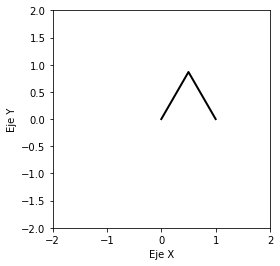

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML 

# Usando el módulo animation y código similar al de la práctica anterior,
# representamos la trayectoria que sigue el robot (asi como el brazo robótico)
# durante el movimiento
def init():
    ax.clear() # Limpiamos los ejes actuales
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_xlim(-2,2) # Establece los límites del eje x
    ax.set_ylim(-2,2) # y del eje y
    ax.set_aspect('equal') # Hace que la proporción de ambos ejes sea 1:1
    
def pcd(L1, L2, th1, th2):
   # Cuerpo de la función 
    px=L1*np.cos(th1)+L2*np.cos(th1+th2)
    py=L1*np.sin(th1)+L2*np.sin(th1+th2)
    pcd=np.c_[px,py]
    return pcd#lo que haya que devolver

def robot(L1,th1,p, ax):
    x=[0, L1*np.cos(th1), p[0]]
    y=[0, L1*np.sin(th1), p[1]]
    ax.plot(x,y, color='k', linewidth=2)
    ax.axis([-2, 2, -2, 2])
    ax.set_aspect('equal')
    
def pintarPCD(i, L1, L2, th1, th2, ax):
    init()
    # Resto de código para elegir el punto actual (i), pintar la trayectoria hasta el punto actual y
    # pintar el robot en esa configuración. 
    p = pcd(L1,L2,th1,th2)
    robot(L1,th1[i],p[i],ax)
    ax.plot(p[:i,0], p[:i,1])
    
# Genera la trayectoria y su correspondiente animación, y la muestra con HTML(anim.to_html5_video())
N = j1.shape[0]
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, pintarPCD, frames = N, fargs = (L1, L2, j1, j2, ax), interval = T) 
HTML(anim.to_jshtml())

## Visualización de las variables
Ahora mostraremos, en función del tiempo: 
1. Los valores de $\theta_1$ y $\theta_2$
2. Los valores de velocidad $v_1$ y $v_2$
3. Los valores de aceleración $a_1$ y $a_2$

Dado que la velocidad y la acelaración son la primera y la segunda derivada de la trayectoria, podemos utilizar `polyder` para obtener sus coeficientes de los polinomios que definen la velocidad y la aceleración y, una vez obtenidos, `polyval` para evaluar las funciones resultantes.


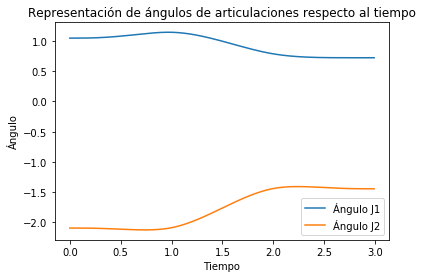

In [23]:
# Obtenemos el vector de muetras de tiempo
t = np.arange(0, t1+t2+tn, T)

# Representamos los ángulos theta1 y theta2 en función del tiempo
plt.plot(t,j1,label="Ángulo J1")
plt.plot(t,j2,label="Ángulo J2")
plt.title("Representación de ángulos de articulaciones respecto al tiempo")
plt.ylabel("Ángulo")
plt.xlabel("Tiempo")
plt.legend(loc=0)


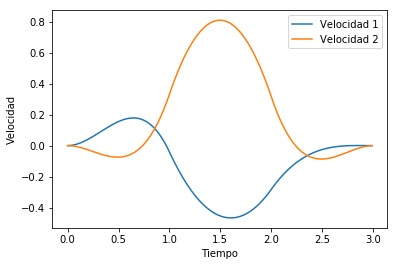

In [25]:
# Calculamos las funciones de la velocidad (derivada de la trayectoria)
from numpy.polynomial.polynomial import polyder
v1_1=np.polyval(np.polyder(h1_1),np.arange(0,1,T))
v2_1=np.polyval(np.polyder(h2_1),np.arange(0,1,T))
vn_1=np.polyval(np.polyder(hn_1),np.arange(-1,0,T))

v1_2=np.polyval(np.polyder(h1_2),np.arange(0,1,T))
v2_2=np.polyval(np.polyder(h2_2),np.arange(0,1,T))
vn_2=np.polyval(np.polyder(hn_2),np.arange(-1,0,T))

v1=np.r_[v1_1,v2_1,vn_1]
v2=np.r_[v1_2,v2_2,vn_2]

# Representamos la velocidad de cada eslabón en función del tiempo
plt.plot(t,v1,label="Velocidad 1")
plt.plot(t,v2,label="Velocidad 2")
plt.title("Representación de velocidad de articulaciones respecto al tiempo")
plt.ylabel("Velocidad")
plt.xlabel("Tiempo")
plt.legend(loc=0)


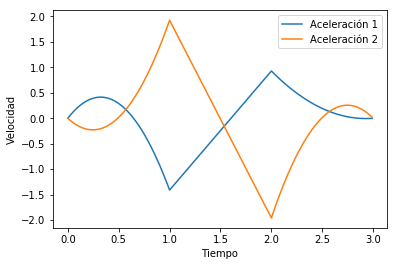

In [28]:
# Calculamos las funciones de la aceleración (derivada de la velocidad)
a1_1=np.polyval(np.polyder(h1_1, m=2),np.arange(0,1,T))
a2_1=np.polyval(np.polyder(h2_1, m=2),np.arange(0,1,T))
an_1=np.polyval(np.polyder(hn_1, m=2),np.arange(-1,0,T))

a1_2=np.polyval(np.polyder(h1_2, m=2),np.arange(0,1,T))
a2_2=np.polyval(np.polyder(h2_2, m=2),np.arange(0,1,T))
an_2=np.polyval(np.polyder(hn_2, m=2),np.arange(-1,0,T))

a1=np.r_[a1_1,a2_1,an_1]
a2=np.r_[a1_2,a2_2,an_2]

# Representamos la aceleración de cada eslabón en función del tiempo
plt.plot(t,a1,label="Aceleración 1")
plt.plot(t,a2,label="Aceleración 2")
plt.title("Representación de acelaración de articulaciones respecto al tiempo")
plt.ylabel("Aceleración")
plt.xlabel("Tiempo")
plt.legend(loc=0)